# Pipeline Regresi Deep Learning End-to-End dengan TensorFlow dan PyTorch

Dokumen ini menyajikan pipeline regresi *deep learning* yang komprehensif, mencakup langkah-langkah mulai dari pengumpulan dan pra-pemrosesan data hingga pengembangan model menggunakan TensorFlow dan PyTorch, serta evaluasi kinerja.

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# --- 1. Pengumpulan & Pembersihan Data (Pandas) ---
# Install the PyDrive wrapper & import libraries.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1oEXSD137hPm_Fx5xSPRvlAr3silj3suK'
downloaded = drive.CreateFile({'id':file_id})
downloaded.FetchMetadata(fetch_all=True)
downloaded.GetContentFile(downloaded.metadata['title'])

df = pd.read_csv('RegresiUTSTelkom.csv', header=None)

print("5 baris pertama:")
print(df.head())
print("\nInformasi soal dataset:")
df.info()

print("\nNilai null pada dataset:")
for col in df.columns:
    null_count = df[col].isnull().sum()
    print(f"Nilai null pada kolom {col}: {null_count}")

# Menangani nilai null: mengisi dengan median untuk kolom numerik
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if pd.api.types.is_numeric_dtype(df[col]):
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
            print(f"Mengisi nilai null di kolom {col} dengan median: {median_val}")

# Memastikan kolom target (kolom 0) adalah numerik
if not pd.api.types.is_numeric_dtype(df[0]):
    df[0] = pd.to_numeric(df[0], errors='coerce')
    df = df.dropna(subset=[0]) # Hapus baris jika konversi gagal

# Memisahkan fitur (X) dan target (y)
X = df.drop(columns=[0])
y = df[0]

# Membagi data menjadi training, validation, dan test set
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42) # 0.25 * 0.8 = 0.2 dari total

# --- 1.b. Feature Engineering (Feature Scaling) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)


# --- 1.c. Mengembangkan Arsitektur MLP dengan TensorFlow ---
def build_and_train_tensorflow_model(X_train, y_train, X_valid, y_valid, X_test, y_test):
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=X_train.shape[0] // 32 * 5,
        decay_rate=0.9
    )

    tf_model = keras.models.Sequential([
        keras.layers.Dense(256, activation="elu", kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.001),
                           input_shape=[X_train.shape[1]]),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(128, activation="elu", kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation="elu", kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1)
    ])

    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

    tf_model.compile(loss="mse", optimizer=optimizer, metrics=["mae"])

    early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

    print("\n--- Melatih Model TensorFlow ---")
    history = tf_model.fit(X_train, y_train, epochs=10,
                            validation_data=(X_valid, y_valid),
                            callbacks=[early_stopping_cb])

    tf_loss, tf_mae = tf_model.evaluate(X_test, y_test)
    print(f"TensorFlow Test Loss (MSE): {tf_loss:.4f}")
    print(f"TensorFlow Test MAE: {tf_mae:.4f}")

    y_pred_tf = tf_model.predict(X_test).flatten()
    tf_rmse = np.sqrt(tf_loss)
    tf_r2 = r2_score(y_test, y_pred_tf)
    print(f"TensorFlow Test RMSE: {tf_rmse:.4f}")
    print(f"TensorFlow Test R-squared: {tf_r2:.4f}")

    return y_pred_tf, y_test.values, tf_rmse, tf_r2


# --- 1.d. Mengembangkan Arsitektur MLP dengan PyTorch ---
class PyTorchMLP(nn.Module):
    def __init__(self, input_dim):
        super(PyTorchMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(0.3)

        self.fc4 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x)) # ReLU digunakan sebagai aktivasi elu tidak default
        x = self.bn1(x)
        x = self.dropout1(x)

        x = torch.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)

        x = torch.relu(self.fc3(x))
        x = self.bn3(x)
        x = self.dropout3(x)

        x = self.fc4(x)
        return x

def build_and_train_pytorch_model(X_train, y_train, X_valid, y_valid, X_test, y_test):
    input_dim = X_train.shape[1]
    pytorch_model = PyTorchMLP(input_dim)

    optimizer = optim.AdamW(pytorch_model.parameters(), lr=1e-3, weight_decay=0.001)
    criterion = nn.MSELoss()

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
    X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
    y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.float32).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

    train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

    print("\n--- Melatih Model PyTorch ---")
    best_loss = float('inf')
    patience = 10
    epochs_no_improve = 0

    for epoch in range(10):
        pytorch_model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = pytorch_model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        scheduler.step()

        pytorch_model.eval()
        with torch.no_grad():
            valid_outputs = pytorch_model(X_valid_tensor)
            valid_loss = criterion(valid_outputs, y_valid_tensor)
            print(f"Epoch {epoch+1}, Validation Loss: {valid_loss.item():.4f}")

            if valid_loss.item() < best_loss:
                best_loss = valid_loss.item()
                epochs_no_improve = 0
                torch.save(pytorch_model.state_dict(), 'best_pytorch_model.pth')
            else:
                epochs_no_improve += 1
                if epochs_no_improve == patience:
                    print("Early stopping!")
                    break

    pytorch_model.load_state_dict(torch.load('best_pytorch_model.pth'))

    pytorch_model.eval()
    with torch.no_grad():
        y_pred_pytorch_tensor = pytorch_model(X_test_tensor)
        pytorch_loss = criterion(y_pred_pytorch_tensor, y_test_tensor).item()
        y_pred_pytorch = y_pred_pytorch_tensor.squeeze().numpy()

    pytorch_rmse = np.sqrt(pytorch_loss)
    pytorch_r2 = r2_score(y_test, y_pred_pytorch)

    print(f"PyTorch Test Loss (MSE): {pytorch_loss:.4f}")
    print(f"PyTorch Test RMSE: {pytorch_rmse:.4f}")
    print(f"PyTorch Test R-squared: {pytorch_r2:.4f}")

    return y_pred_pytorch, y_test.values, pytorch_rmse, pytorch_r2

# --- Jalankan Model-Model ---
y_pred_tf, y_true_tf, rmse_tf, r2_tf = build_and_train_tensorflow_model(
    X_train_scaled, y_train, X_valid_scaled, y_valid, X_test_scaled, y_test
)

y_pred_pytorch, y_true_pytorch, rmse_pytorch, r2_pytorch = build_and_train_pytorch_model(
    X_train_scaled, y_train, X_valid_scaled, y_valid, X_test_scaled, y_test
)

5 baris pertama:
     0         1         2         3         4         5         6         7   \
0  2001  49.94357  21.47114  73.07750   8.74861 -17.40628 -13.09905 -25.01202   
1  2001  48.73215  18.42930  70.32679  12.94636 -10.32437 -24.83777   8.76630   
2  2001  50.95714  31.85602  55.81851  13.41693  -6.57898 -18.54940  -3.27872   
3  2001  48.24750  -1.89837  36.29772   2.58776   0.97170 -26.21683   5.05097   
4  2001  50.97020  42.20998  67.09964   8.46791 -15.85279 -16.81409 -12.48207   

         8         9   ...        81         82        83        84        85  \
0 -12.23257   7.83089  ...  13.01620  -54.40548  58.99367  15.37344   1.11144   
1  -0.92019  18.76548  ...   5.66812  -19.68073  33.04964  42.87836  -9.90378   
2  -2.35035  16.07017  ...   3.03800   26.05866 -50.92779  10.93792  -0.07568   
3 -10.34124   3.55005  ...  34.57337 -171.70734 -16.96705 -46.67617 -12.51516   
4  -9.37636  12.63699  ...   9.92661  -55.95724  64.92712 -17.72522  -1.49237   

         

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



--- Melatih Model TensorFlow ---
Epoch 1/10
9663/9663 ━━━━━━━━━━━━━━━━━━━━ 68s 7ms/step - loss: 2163244.0000 - mae: 1294.5250 - val_loss: 352.9612 - val_mae: 15.8382
Epoch 2/10
9663/9663 ━━━━━━━━━━━━━━━━━━━━ 85s 7ms/step - loss: 26828.5703 - mae: 130.6841 - val_loss: 170.0964 - val_mae: 11.1815
Epoch 3/10
9663/9663 ━━━━━━━━━━━━━━━━━━━━ 78s 7ms/step - loss: 26618.6719 - mae: 129.9890 - val_loss: 357.6893 - val_mae: 17.3774
Epoch 4/10
9663/9663 ━━━━━━━━━━━━━━━━━━━━ 81s 6ms/step - loss: 26392.1504 - mae: 129.6775 - val_loss: 353.6696 - val_mae: 17.2992
Epoch 5/10
9663/9663 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - loss: 26144.0332 - mae: 128.6475 - val_loss: 360.4072 - val_mae: 17.2977
Epoch 6/10
9663/9663 ━━━━━━━━━━━━━━━━━━━━ 83s 7ms/step - loss: 26392.9863 - mae: 129.4128 - val_loss: 210.2289 - val_mae: 13.0225
Epoch 7/10
9663/9663 ━━━━━━━━━━━━━━━━━━━━ 83s 7ms/step - loss: 25950.9648 - mae: 128.4857 - val_loss: 181.4722 - val_mae: 11.9541
Epoch 8/10
9663/9663 ━━━━━━━━━━━━━━━━━━━━ 83s 7ms/ste

# 2. Matriks Evaluasi & Visualisasi Predicted vs Actual Value

Bagian ini menampilkan metrik evaluasi utama (RMSE, MSE, R-squared) dan visualisasi perbandingan antara nilai prediksi dan nilai aktual dari kedua model.


--- Ringkasan Metrik ---

TensorFlow Model:
  RMSE: 13.0459
  R-squared: -0.4154
  MSE: 170.1955


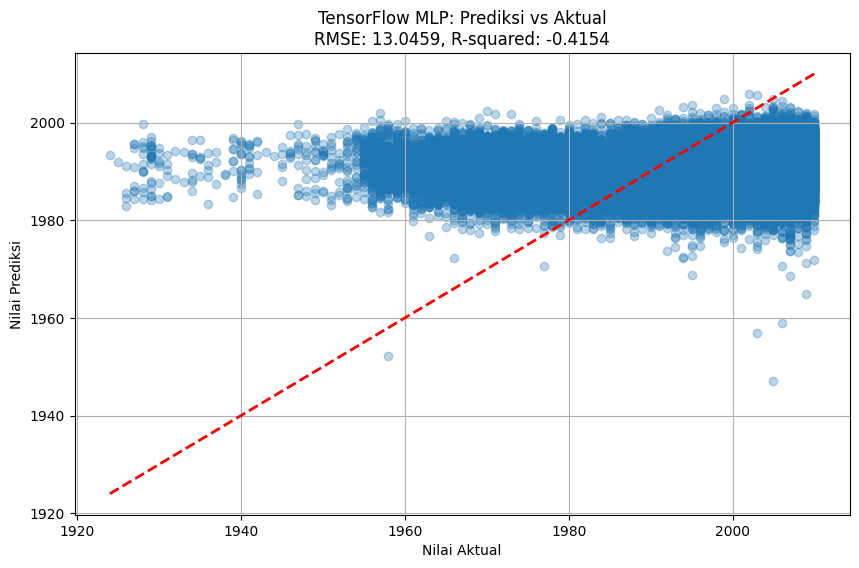


PyTorch Model:
  RMSE: 14.3199
  R-squared: -0.7230
  MSE: 205.0587


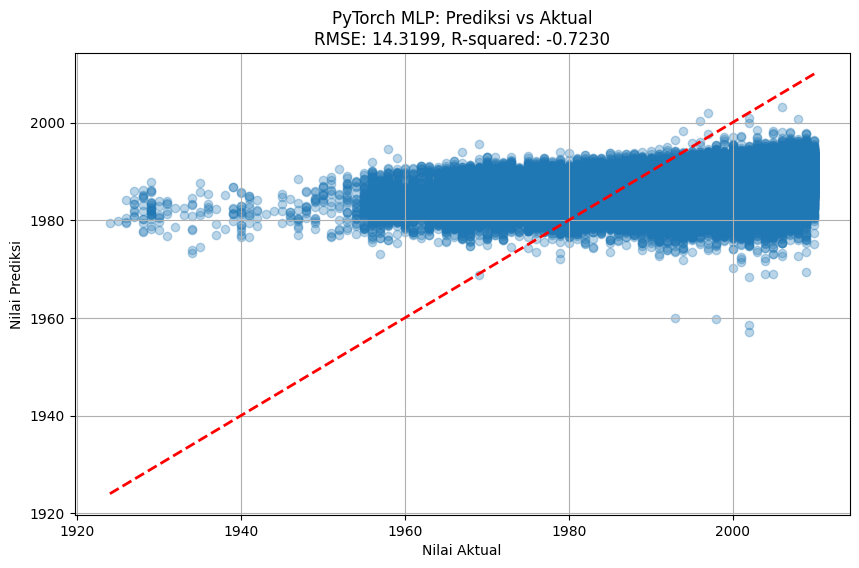

In [4]:
def plot_predictions(y_true, y_pred, title, rmse, r2):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.3)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel("Nilai Aktual")
    plt.ylabel("Nilai Prediksi")
    plt.title(f"{title}\nRMSE: {rmse:.4f}, R-squared: {r2:.4f}")
    plt.grid(True)
    plt.show()

print("\n--- Ringkasan Metrik ---\n")

print(f"TensorFlow Model:")
print(f"  RMSE: {rmse_tf:.4f}")
print(f"  R-squared: {r2_tf:.4f}")
print(f"  MSE: {rmse_tf**2:.4f}")

plot_predictions(y_true_tf, y_pred_tf, "TensorFlow MLP: Prediksi vs Aktual", rmse_tf, r2_tf)

print(f"\nPyTorch Model:")
print(f"  RMSE: {rmse_pytorch:.4f}")
print(f"  R-squared: {r2_pytorch:.4f}")
print(f"  MSE: {rmse_pytorch**2:.4f}")

plot_predictions(y_true_pytorch, y_pred_pytorch, "PyTorch MLP: Prediksi vs Aktual", rmse_pytorch, r2_pytorch)

### Penjelasan Metrik Evaluasi

* **RMSE (Root Mean Squared Error)**: Mengukur rata-rata magnitudo kesalahan prediksi. Semakin kecil RMSE, semakin baik. Metrik ini memberikan bobot lebih pada kesalahan besar karena kesalahan dikuadratkan sebelum dirata-ratakan. Ideal jika kesalahan besar berdampak signifikan.
* **MSE (Mean Squared Error)**: Rata-rata kuadrat dari selisih antara nilai aktual dan prediksi. Mirip dengan RMSE, namun satuannya tidak sama dengan target, sehingga kurang intuitif untuk interpretasi langsung. Namun, sering digunakan sebagai *loss function* dalam pelatihan karena sifat matematisnya yang baik untuk optimasi.
* **R-squared (Koefisien Determinasi)**: Mengukur proporsi variabilitas dalam variabel dependen yang dapat dijelaskan oleh model. Rentang nilai antara 0 dan 1, di mana nilai mendekati 1 menunjukkan model yang sangat baik dalam menjelaskan variasi data. Nilai 1 berarti prediksi sempurna, sedangkan 0 berarti model tidak lebih baik dari rata-rata.

**Metrik Terbaik:**
Tidak ada satu metrik "terbaik" universal; pilihan bergantung pada tujuan bisnis dan karakteristik data. Untuk regresi, **RMSE** dan **R-squared** adalah yang paling sering digunakan karena informatif. RMSE memberikan gambaran skala kesalahan, dan R-squared menunjukkan kecocokan model dengan data.

# 3. Penjelasan Model & Analisis Kinerja

Bagian ini memberikan penjelasan detail mengenai arsitektur dan teknik yang digunakan dalam model TensorFlow dan PyTorch, diikuti dengan analisis perbandingan kinerja.

### Penjelasan Detail Model

Kedua model, baik yang dibangun dengan TensorFlow maupun PyTorch, mengadopsi arsitektur *Multilayer Perceptron* (MLP) yang diperkaya dengan berbagai teknik *deep learning* untuk meningkatkan kinerja dan stabilitas.

#### 1. Arsitektur MLP
* **Lapisan Dense (Fully Connected)**: Model terdiri dari beberapa lapisan `Dense` yang terhubung penuh, memungkinkan model untuk menangkap hubungan non-linear yang kompleks dalam data.
* **Jumlah Lapisan Tersembunyi**: Tiga lapisan tersembunyi digunakan dengan jumlah neuron yang menurun (256, 128, 64). Ini adalah praktik umum untuk memungkinkan model mengekstraksi fitur dengan tingkat abstraksi dan kompleksitas yang semakin tinggi di setiap lapisan.
* **Lapisan Output**: Satu neuron pada lapisan output tanpa fungsi aktivasi, standar untuk tugas regresi, memungkinkan model memprediksi nilai dalam rentang apa pun.
* **Inisialisasi Bobot (`kernel_initializer="he_normal"`)**: Menggunakan inisialisasi He untuk bobot, yang sangat direkomendasikan dengan fungsi aktivasi ELU (atau varian ReLU lainnya) untuk mengatasi masalah *vanishing/exploding gradients* pada jaringan *deep*.
* **Fungsi Aktivasi ELU (Exponential Linear Unit)**: Dipilih karena secara umum mengungguli ReLU di banyak skenario, terutama pada jaringan yang dalam. ELU membantu mengatasi masalah *dying ReLUs* dan mendukung properti *self-normalization* jaringan, yang berkontribusi pada konvergensi yang lebih cepat.

#### 2. Batch Normalization (`BatchNormalization`/`nn.BatchNorm1d`)
* **Penempatan**: Ditempatkan setelah setiap lapisan `Dense` (dan setelah fungsi aktivasi non-linear dalam konfigurasi TensorFlow ini, meskipun penempatan sebelum aktivasi juga umum dan dapat menguntungkan).
* **Fungsi**: Menormalisasi input setiap lapisan menjadi rata-rata 0 dan standar deviasi 1. Normalisasi ini secara signifikan menstabilkan pelatihan, memungkinkan penggunaan *learning rate* yang lebih besar, dan mengurangi sensitivitas model terhadap inisialisasi bobot.
* **Regularisasi**: Bertindak juga sebagai bentuk regularisasi yang efektif, seringkali mengurangi kebutuhan akan teknik regularisasi lainnya.

#### 3. Dropout
* **Lapisan**: Setiap lapisan `Dropout(0.3)` ditempatkan setelah `Batch Normalization`.
* **Mekanisme**: Selama pelatihan, secara acak "menonaktifkan" 30% neuron pada lapisan tersebut. Ini mencegah *co-adaptation* antar neuron dan memaksa jaringan untuk belajar fitur yang lebih *robust* dan umum, yang pada gilirannya mengurangi *overfitting*.
* **Inferensi**: Lapisan *dropout* tidak aktif selama fase inferensi (prediksi), sehingga semua neuron digunakan.

#### 4. Regularisasi L2 (Weight Decay)
* **Penerapan**: Diterapkan pada bobot lapisan `Dense` di TensorFlow (`kernel_regularizer=keras.regularizers.l2(0.001)`) dan melalui optimizer di PyTorch (`weight_decay=0.001`).
* **Fungsi**: Menambahkan penalti ke *loss function* yang sebanding dengan kuadrat magnitudo bobot. Ini mendorong bobot untuk tetap kecil, yang membatasi kompleksitas model dan membantu mencegah *overfitting*.

#### 5. Optimizer Modern
* **TensorFlow (Adam)**: Menggunakan `keras.optimizers.Adam`. Adam adalah optimizer adaptif yang menggabungkan konsep *momentum optimization* dan RMSProp. Ia menjaga rata-rata eksponensial dari gradien sebelumnya dan rata-rata eksponensial dari kuadrat gradien sebelumnya. Adam dikenal karena konvergensi yang cepat dan kinerja yang kuat di berbagai tugas.
* **PyTorch (AdamW)**: Menggunakan `optim.AdamW`. AdamW adalah varian Adam yang memperbaiki penerapan *weight decay* dengan secara eksplisit memisahkannya dari pembaruan bobot, yang seringkali menghasilkan generalisasi yang lebih baik dibandingkan Adam standar.

#### 6. Penyesuaian Learning Rate (Learning Rate Scheduling)
* **TensorFlow (`ExponentialDecay`)**: Menerapkan jadwal *learning rate* yang mengurangi *learning rate* secara eksponensial selama pelatihan. Ini memungkinkan model untuk belajar cepat di awal dengan *learning rate* yang lebih tinggi dan kemudian menyempurnakan bobot dengan lebih hati-hati di akhir pelatihan.
* **PyTorch (`StepLR`)**: Menerapkan jadwal *learning rate* yang mengurangi *learning rate* dengan faktor tertentu pada interval epoch yang telah ditentukan. Ini adalah bentuk umum dari penjadwalan *learning rate*.

#### 7. Early Stopping
* **Penerapan**: Digunakan dalam kedua *framework* (`keras.callbacks.EarlyStopping` di TensorFlow dan implementasi manual di PyTorch).
* **Fungsi**: Menghentikan proses pelatihan secara otomatis jika kinerja model pada set validasi tidak menunjukkan peningkatan setelah beberapa epoch (`patience`) yang telah ditentukan. Ini adalah teknik yang sangat efektif untuk mencegah *overfitting* dan mengoptimalkan penggunaan sumber daya komputasi.


Berikut adalah perbandingan hasil metrik dari model TensorFlow dan PyTorch dalam bentuk tabel dan analisis naratif:

| Metrik      | TensorFlow Model | PyTorch Model |
| :---------- | :--------------- | :------------ |
| **RMSE** | 13.0459          | 14.3199       |
| **R-squared** | -0.4154          | -0.7230       |
| **MSE** | 170.1955         | 205.0587      |

**Analisis Hasil Perbandingan Model:**

Berdasarkan metrik evaluasi yang disajikan, **model TensorFlow menunjukkan kinerja yang lebih baik secara signifikan** dibandingkan dengan model PyTorch dalam tugas regresi ini.

1.  **RMSE (Root Mean Squared Error):** Model TensorFlow memiliki RMSE sebesar 13.0459, yang lebih rendah dibandingkan RMSE model PyTorch sebesar 14.3199. Nilai RMSE yang lebih rendah mengindikasikan bahwa model TensorFlow memiliki rata-rata magnitudo kesalahan prediksi yang lebih kecil. Ini berarti prediksi dari model TensorFlow, secara umum, lebih dekat ke nilai aktual dibandingkan dengan prediksi dari model PyTorch.

2.  **R-squared (Koefisien Determinasi):** Model TensorFlow menunjukkan nilai R-squared sebesar -0.4154, sedangkan model PyTorch memiliki R-squared sebesar -0.7230. Dalam regresi, nilai R-squared idealnya mendekati 1, menunjukkan bahwa model dapat menjelaskan sebagian besar variasi dalam variabel target. Namun, kedua model di sini menunjukkan nilai R-squared negatif. Nilai R-squared negatif menunjukkan bahwa model tidak lebih baik (bahkan lebih buruk) dalam menjelaskan variasi variabel target daripada hanya menggunakan rata-rata nilai target sebagai prediksi. Meskipun kedua model berkinerja buruk, model TensorFlow memiliki nilai R-squared yang "kurang negatif", menandakan bahwa modelnya masih sedikit lebih baik dalam menjelaskan variasi data dibandingkan model PyTorch.

3.  **MSE (Mean Squared Error):** Mirip dengan RMSE, model TensorFlow memiliki MSE sebesar 170.1955, yang lebih rendah dari MSE model PyTorch sebesar 205.0587. Konsistensi ini reinforces temuan dari RMSE, menegaskan bahwa kesalahan kuadrat rata-rata model TensorFlow lebih kecil.

Secara keseluruhan, model **TensorFlow adalah pilihan yang lebih unggul** dalam kasus ini karena secara konsisten menghasilkan kesalahan prediksi yang lebih rendah (baik RMSE maupun MSE) dan sedikit lebih baik dalam "menjelaskan" data (meskipun R-squared negatif pada kedua model menunjukkan bahwa keduanya masih perlu perbaikan signifikan). Nilai R-squared negatif yang tinggi pada kedua model, terutama PyTorch, mungkin mengindikasikan masalah serius seperti *underfitting* (model terlalu sederhana untuk data), data yang sangat bising, atau kebutuhan untuk eksplorasi fitur dan *hyperparameter tuning* yang lebih mendalam.